# PREVISIONS DE SERIES TEMPORELLES FINANCIERES

<a id='sommaire'></a>
# SOMMAIRE

* [1. Importation et Visualisation](#chapter1)

* [2. Stationnarité](#chapter2)
    * [2.1 ADF](#section_2_1)
    * [2.2 Rendement](#section_2_2)
           
* [3. Modèles](#chapter3)
    * [3.1 ARIMA](#section_3_1)
        * [3.1.1 Prévision du modèle](#section_3_1_1)
        * [3.1.2 Hold Winters](#section_3_1_2)
    * [3.2 GARCH](#section_3_2)
    * [3.3 VAR](#section_3_3)
    * [3.4 Deep Learning](#section_3_4)

# 1. IMPORTATION ET VISUALISATION <a class="anchor" id="chapter1"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_squared_error

! pip install yfinance
import yfinance as yf

! pip install pmdarima
import pmdarima

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import math

from pmdarima.arima import auto_arima

from arch import arch_model

from datetime import datetime, timedelta

from arch.univariate import ARX, ConstantMean
from arch.univariate import ARCH, GARCH

import seaborn as sns

!pip install pandas_datareader
import pandas_datareader as pdr

from tqdm import tqdm_notebook
from itertools import product

import pandas_datareader.data as web

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import TimeDistributed
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Input, Activation, concatenate

!pip install pandas-ta
import pandas_ta as ta

import warnings
warnings.filterwarnings("ignore")

**Dans ce porjet, nous étudirons le prix du SP500 du 1er Janvier 2013 au 1er Janvier 2023 en fréquence journalière**

In [2]:
# On télécharge les données boursières quotidiennes via Yahoo Finance

données = yf.download('^GSPC' ,start="2013-01-01", end="2023-01-01", interval="1d")
df = données['Close']

[*********************100%***********************]  1 of 1 completed


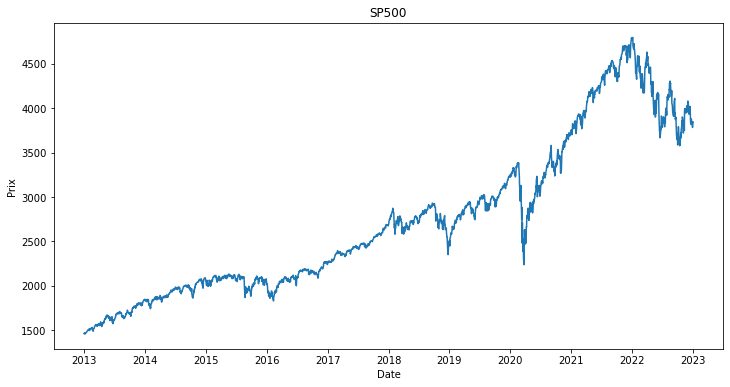

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('SP500')
plt.show()

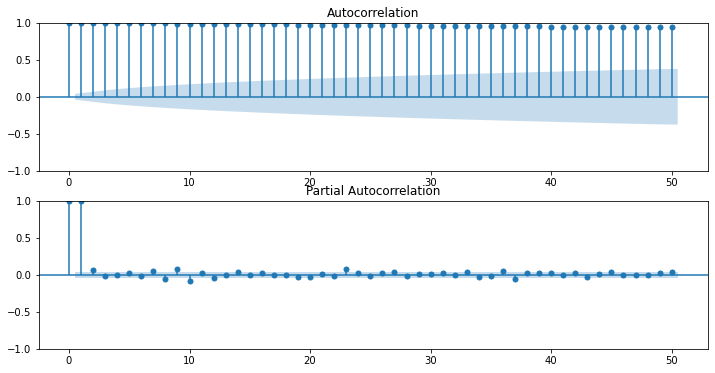

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
plot_acf(df, ax=ax[0], lags=50)
plot_pacf(df, ax=ax[1], lags=50)
plt.show()

**L'ACF ne décroit pas rapidement vers 0 ce qui est une caractéristique de séries non stationnaires**

# 2. STATIONNARITE <a class="anchor" id="chapter2"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

**La stationnarité permet de savoir si la structure du processus sous-jacent évolue ou non avec le temps. Si une série temporelle n’est pas stationnaire, cela peut rendre difficile la prédiction de ses valeurs futures. En effet, les modèles de prédiction de séries temporelles sont souvent basés sur l’hypothèse que la série est stationnaire. C’est pourquoi il est important de vérifier la stationnarité d’une série temporelle avant d’effectuer des prévisions. Nous allons donc utliser pour ça le test de Dickey Fuller Augmenté.**

## 2.1 ADF <a class="anchor" id="section_2_1"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

In [5]:
# On convertit df en array pour pouvoir utiliser adfuller
dftest = df.to_numpy()
type(dftest)

numpy.ndarray

In [6]:
result = adfuller(dftest,regression='ct', autolag='AIC', regresults=True)
result[3].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     12.70
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           1.30e-25
Time:                        13:43:49   Log-Likelihood:                -12286.
No. Observations:                2507   AIC:                         2.460e+04
Df Residuals:                    2494   BIC:                         2.467e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0057      0.002     -2.534      0.011      -0.010      -0.001
x2            -0.0656      0.020     -3.276      0.001      -0.105      -0.026
x3             0.0307      0.020      1.536      0.125      -0.008       0.070
x4             0.0062      0.020      0.310      0.756      -0.033       0.045
x5            -0.0493      0.020     -2.484      0.013      -0.088      -0.010
x6             0.0220      0.020      1.109      0.267      -0.017       0.061
x7            -0.0646      0.020     -3.258      0.001      -0.103      -0.026
x8             0.0903      0.020      4.551      0.000       0.051       0.129
x9            -0.0786      0.020     -3.944      0.000      -0.118      -0.040
x10            0.1074      0.020      5.372      0.000       0.068       0.147
x11           -0.0405      0.020     -2.017      0.044      -0.080      -0.001
const          8.7807      3.249      2.702      0.007       2.409      15.152
x12            0.0063      0.003      2.323      0.020       0.001       0.012
==============================================================================
Omnibus:                      626.282   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7326.186
Skew:                          -0.840   Prob(JB):                         0.00
Kurtosis:                      11.204   Cond. No.                     1.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**t-stat de la tendance = 2.323< 2,79 (à 5% et à 100 obsevations), on accepte l'hypothèse nulle de non-significativité, la tendance n'est pas significative.**

In [7]:
result = adfuller(dftest,regression='c', autolag='AIC', regresults=True)
result[3].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     13.34
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           4.27e-25
Time:                        13:43:49   Log-Likelihood:                -12289.
No. Observations:                2507   AIC:                         2.460e+04
Df Residuals:                    2495   BIC:                         2.467e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0008      0.001     -1.031      0.303      -0.002       0.001
x2            -0.0682      0.020     -3.413      0.001      -0.107      -0.029
x3             0.0279      0.020      1.396      0.163      -0.011       0.067
x4             0.0035      0.020      0.177      0.859      -0.035       0.043
x5            -0.0522      0.020     -2.631      0.009      -0.091      -0.013
x6             0.0194      0.020      0.979      0.328      -0.019       0.058
x7            -0.0672      0.020     -3.394      0.001      -0.106      -0.028
x8             0.0879      0.020      4.431      0.000       0.049       0.127
x9            -0.0812      0.020     -4.078      0.000      -0.120      -0.042
x10            0.1049      0.020      5.251      0.000       0.066       0.144
x11           -0.0430      0.020     -2.142      0.032      -0.082      -0.004
const          3.1338      2.158      1.452      0.147      -1.097       7.365
==============================================================================
Omnibus:                      597.549   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7107.558
Skew:                          -0.780   Prob(JB):                         0.00
Kurtosis:                      11.100   Cond. No.                     9.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**t-stat_constante = 1,452 < 2,54 On accepte l'hypothèse nulle de non-significativité, la constante n'est pas significative.**

In [8]:
result = adfuller(dftest,regression='n', autolag='AIC', regresults=True)
result

(1.1620968212278446,
 0.9362826788177466,
 {'1%': -2.5666323999796976,
  '5%': -1.9411076734239736,
  '10%': -1.616714486850099},
 <statsmodels.stats.diagnostic.ResultsStore at 0x201b8debac0>)

**1.16 > -1,941 on accepte l'hypothèse nulle de non-stationnarité, la série du PIB n'est pas stationnaire.**

## 2.2 Rendement <a class="anchor" id="section_2_2"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

**Pour résoudre notre problème de non stationnarité nous allons allons étudier les rendements de notre sous-jacent**

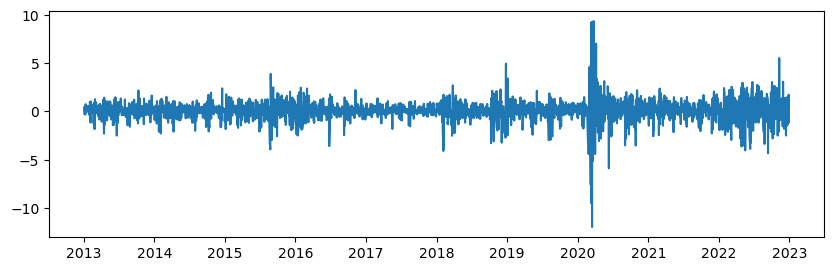

In [9]:
rend = (100 * df.pct_change())
rend = rend.dropna()

figure(figsize=(10, 3), dpi=100)
plt.plot(rend)

In [10]:
rendtest = rend.to_numpy()

In [11]:
result = adfuller(rendtest,regression='n', autolag='AIC', regresults=True)
result

(-15.800635885607564,
 1.5320743297900358e-27,
 {'1%': -2.5666323999796976,
  '5%': -1.9411076734239736,
  '10%': -1.616714486850099},
 <statsmodels.stats.diagnostic.ResultsStore at 0x201b9726e20>)

**-15.8 < -1,941 on rejette l'hypothèse nulle de non-stationnarité, la série du rendement est stationnaire.**

# 3. IDENTIFICATION DU MODELE <a class="anchor" id="chapter3"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

## 3.1 ARIMA <a class="anchor" id="section_3_1"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

**Pour savoir quels sont les paramètre ARIMA de notre serie nous allons utiliser la fonction auto_arima qui permet de trouver automatiquement les meilleurs hyperparamètres pour un modèle ARIMA en effectuant une recherche exhaustive et en sélectionnant le modèle avec le meilleur critère d'information**

In [20]:
# Création d'un modèle ARIMA automatique en utilisant les données de la variable "rend"
model = auto_arima(rend, start_p=0, start_q=0,
                          max_p=10, max_q=10,
                          start_P=0, seasonal=False,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True, information_criterion='bic')
print(model.summary())

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=7668.241, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=7621.905, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=7628.784, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=7619.296, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : BIC=7627.051, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=7627.104, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=7622.709, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : BIC=7634.956, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=7622.301, Time=0.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.871 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -3797.902
Date:                Sun, 23 Apr 2023   AIC      

In [21]:
model

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**Le modèle choisi sera donc un ARIMA(2,0,0)**

### 3.1.1 Prevision du modèle <a class="anchor" id="section_3_1_1"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

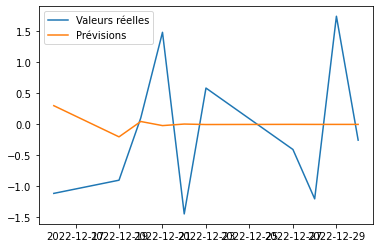

In [14]:
# Diviser les données en ensembles d'apprentissage et de test
train = rend.iloc[:len(rend)-10]
test = rend.iloc[len(rend)-10:]

# Ajuster le modèle sur l'ensemble d'apprentissage
model.fit(train)

# Prévoir les valeurs pour l'ensemble de test
forecast = model.predict(n_periods=len(test))

# Tracer les prévisions et les valeurs réelles
plt.plot(test.index, test, label='Valeurs réelles')
plt.plot(test.index, forecast, label='Prévisions')
plt.legend()
plt.show()


### 3.1.2 Hold Winters <a class="anchor" id="section_3_1_2"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

**La méthode de Holt-Winters (également connue sous le nom de lissage exponentiel triple) est une méthode de prévision des séries chronologiques qui est utilisée pour estimer la tendance, l'effet saisonnier et le niveau de bruit dans les données**

In [15]:
rend2 = rend.reset_index(drop = True)

In [16]:
# en utilisant Hold Winters avec un modèle Multiplicatif,toutes nos données doivent être positives
# on ajoute alors 20 à toutes nos données pour qu'elles le soient
rend2 = rend2 + 20

In [17]:
len(rend2)

2517

In [18]:
train=rend2[:2500]
test=rend2[2499:]

In [19]:
hwmodel=ExponentialSmoothing(train,trend='mul', seasonal='mul', seasonal_periods=365).fit()

In [20]:
test_pred=hwmodel.forecast(20)

<AxesSubplot:>

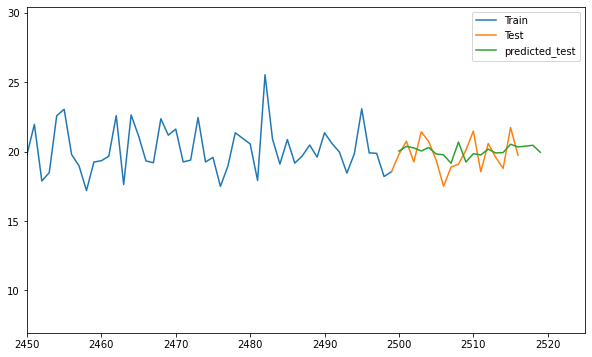

In [21]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend=True, label='Test')
plt.xlim(2450, 2525)

test_pred.plot(legend=True, label='predicted_test')

## 3.2 GARCH <a class="anchor" id="section_3_2"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

**Les modèles GARCH (Generalized Autoregressive Conditional Heteroskedasticity) sont des modèles de volatilité des séries chronologiques qui permettent de modéliser la variance conditionnelle et de prendre en compte l'hétéroscédasticité dans les données.**

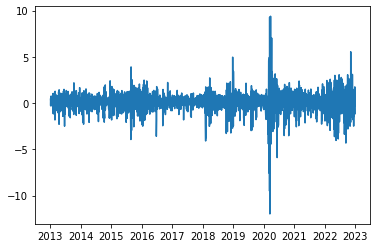

In [22]:
plt.plot(rend)

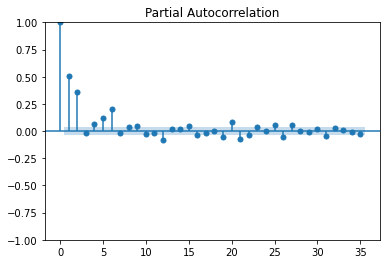

In [23]:
plot_pacf(rend**2)
plt.show()

In [95]:
testrend = rend.to_numpy()

In [100]:
p = range(1, 5)
q = range(1, 5)

# Initialiser les variables pour stocker les résultats
best_aic = np.inf
best_order = None
best_model = None

# Boucle sur toutes les combinaisons possibles de p et q
for i in p:
    for j in q:
        # Ajuster le modèle GARCH(i, j)
        model = arch_model(testrend, p=i, q=j)
        res = model.fit(disp='off')
        
        # Comparer l'AIC avec le meilleur AIC actuel
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (i, j)
            best_model = model

# Afficher les résultats
print(f'Meilleur modèle GARCH: {best_order}')


Meilleur modèle GARCH: (1, 1)


In [24]:
# Création d'un modèle GARCH(1,1) en utilisant les données de la variable "rend"
model = arch_model(rend, p=1, q=1)

# Ajustement du modèle aux données
model_fit = model.fit()

# Affichage du résumé du modèle ajusté
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30370.361316431037
Iteration:      2,   Func. Count:     17,   Neg. LLF: 14419.159165148954
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5391.038751112377
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3210.453303792985
Iteration:      5,   Func. Count:     41,   Neg. LLF: 3136.401855615027
Iteration:      6,   Func. Count:     46,   Neg. LLF: 3137.92449988348
Iteration:      7,   Func. Count:     52,   Neg. LLF: 3136.3870092445795
Iteration:      8,   Func. Count:     57,   Neg. LLF: 3136.386497170957
Iteration:      9,   Func. Count:     62,   Neg. LLF: 3136.386484512472
Iteration:     10,   Func. Count:     66,   Neg. LLF: 3136.386484512542
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3136.386484512472
            Iterations: 10
            Function evaluations: 66
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3136.39
Distribution:                  Normal   AIC:                           6280.77
Method:            Maximum Likelihood   BIC:                           6304.10
                                        No. Observations:                 2517
Date:                Sat, Apr 22 2023   Df Residuals:                     2516
Time:                        14:46:53   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0823  1.415e-02      5.815  6.053e-09 [5.454e-02,  0.110]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0399  9.245e-03      4.318  1.573e-05 [2.180e-02,5.804e-02]
alpha[1]       0.2101  3.146e-02      6.678  2.430e-11     [  0.148,  0.272]
beta[1]        0.7606  2.870e-02     26.502 9.255e-155     [  0.704,  0.817]
============================================================================

Covariance estimator: robust
"""

In [25]:
rolling_predictions = []
test_size = 365

# Boucle pour effectuer des prévisions en utilisant un modèle GARCH roulant
for i in range(test_size):
    train = rend[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    # Prévision de la variance pour l'horizon 1
    pred = model_fit.forecast(horizon=1)
    # Ajout de la prévision à la liste des prévisions roulantes
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [26]:
rolling_predictions = pd.Series(rolling_predictions, index=rend.index[-365:])

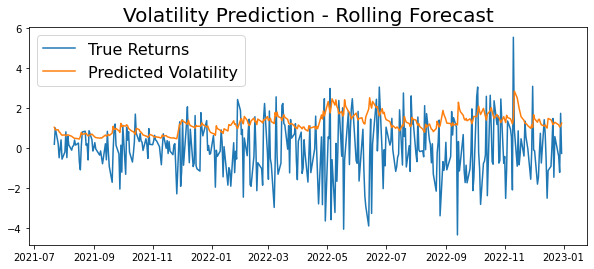

In [27]:
plt.figure(figsize=(10,4))
true, = plt.plot(rend[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [28]:
# Prévision de la variance pour un horizon de 7 jours
pred = model_fit.forecast(horizon=7)

# Création d'une liste de dates futures pour les prévisions
future_dates = [rend.index[-1] + timedelta(days=i) for i in range(1,8)]

# Création d'une série Pandas avec les prévisions et les dates futures comme index
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

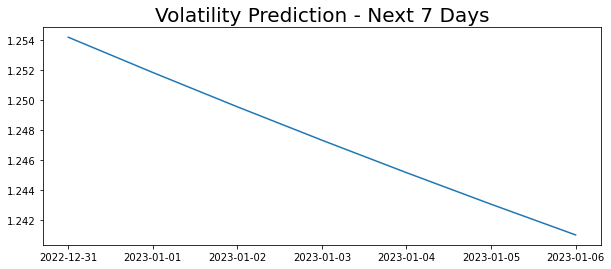

In [29]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)

## 3.3 VAR <a class="anchor" id="section_3_3"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>

**Nous allons ici tenter de faire une prévision du modève VAR à 4 Variables : le SP500, taux d'interet, inflation et production industrielles au Etats-Unis**

In [56]:
# Importation des données et concaténation
données = yf.download('^GSPC' ,start="2013-01-01", end="2023-01-01", interval="1d")
df = données['Close']

TI = pdr.get_data_fred("DGS10", start="2013-01-01", end="2023-01-01", timeout=60)

inflation = web.DataReader('CPALTT01USM657N', 'fred', start="2013-01-01", end="2023-01-01")

industrial_production = web.DataReader('INDPRO', 'fred', start="2013-01-01", end="2023-01-01")

DF = pd.concat([df, TI, inflation, industrial_production], axis=1)
DF.columns = ['SP500','TI','IPC','Prod']

DF=DF.dropna()
DF

[*********************100%***********************]  1 of 1 completed


,SP500,TI,IPC,Prod
2013-02-01,1513.170044,2.04,0.819003,98.6733
2013-03-01,1518.199951,1.86,0.261451,99.0788
2013-04-01,1562.170044,1.86,-0.103964,98.9658
2013-05-01,1582.699951,1.66,0.178041,99.0567
2013-07-01,1614.959961,2.50,0.039400,98.9258
...,...,...,...,...
2022-07-01,3825.330078,2.88,-0.011812,103.1328
2022-08-01,4118.629883,2.60,-0.035440,103.2344
2022-09-01,3966.850098,3.26,0.215078,103.5283
2022-11-01,3856.100098,4.07,-0.101003,103.0719


In [57]:
model = VAR(DF.diff()[1:])

In [80]:
results = model.fit(maxlags=8, ic='aic')

In [81]:
lag_order = results.k_ar
lag_order

1

**on nous préconise de prendre un retard de 1 pour notre modèle**

In [82]:
results = model.fit(lag_order)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Apr, 2023
Time:                     15:47:58
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    7.52023
Nobs:                     76.0000    HQIC:                   7.15201
Log likelihood:          -673.819    FPE:                    999.890
AIC:                      6.90688    Det(Omega_mle):         774.937
--------------------------------------------------------------------
Results for equation SP500
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           46.422963        17.782227            2.611           0.009
L1.SP500        -0.289008         0.128553           -2.248           0.025
L1.TI         -151.545849        66.814557           -2.268           0.023
L1.I

In [83]:
# effectuer le test de causalité de Granger
test = grangercausalitytests(DF[['SP500', 'TI']], maxlag=[3], addconst=True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3740  , p=0.0233  , df_denom=68, df_num=3
ssr based chi2 test:   chi2=11.1641 , p=0.0109  , df=3
likelihood ratio test: chi2=10.4074 , p=0.0154  , df=3
parameter F test:         F=3.3740  , p=0.0233  , df_denom=68, df_num=3


**On observe une causalité a 2%**

In [84]:
test = grangercausalitytests(DF[['TI', 'SP500']], maxlag=[3], addconst=True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2814  , p=0.8386  , df_denom=68, df_num=3
ssr based chi2 test:   chi2=0.9312  , p=0.8179  , df=3
likelihood ratio test: chi2=0.9255  , p=0.8193  , df=3
parameter F test:         F=0.2814  , p=0.8386  , df_denom=68, df_num=3


**La causalité inverse ici est à 80%, Le taux d'interet causse le SP500**

In [85]:
# effectuer le test de causalité de Granger
test = grangercausalitytests(DF[['SP500', 'IPC']], maxlag=[3], addconst=True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9495  , p=0.4217  , df_denom=68, df_num=3
ssr based chi2 test:   chi2=3.1418  , p=0.3703  , df=3
likelihood ratio test: chi2=3.0778  , p=0.3798  , df=3
parameter F test:         F=0.9495  , p=0.4217  , df_denom=68, df_num=3


In [86]:
test = grangercausalitytests(DF[['IPC', 'SP500']], maxlag=[3], addconst=True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2410  , p=0.0083  , df_denom=68, df_num=3
ssr based chi2 test:   chi2=14.0326 , p=0.0029  , df=3
likelihood ratio test: chi2=12.8636 , p=0.0049  , df=3
parameter F test:         F=4.2410  , p=0.0083  , df_denom=68, df_num=3


**l'ipc ne cause pas le SP500**

In [87]:
# effectuer le test de causalité de Granger
test = grangercausalitytests(DF[['SP500', 'Prod']], maxlag=[3], addconst=True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5932  , p=0.0006  , df_denom=68, df_num=3
ssr based chi2 test:   chi2=21.8158 , p=0.0001  , df=3
likelihood ratio test: chi2=19.1492 , p=0.0003  , df=3
parameter F test:         F=6.5932  , p=0.0006  , df_denom=68, df_num=3


In [88]:
test = grangercausalitytests(DF[['Prod', 'SP500']], maxlag=[3], addconst=True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2108  , p=0.8886  , df_denom=68, df_num=3
ssr based chi2 test:   chi2=0.6976  , p=0.8738  , df=3
likelihood ratio test: chi2=0.6944  , p=0.8745  , df=3
parameter F test:         F=0.2108  , p=0.8886  , df_denom=68, df_num=3


**La production industrielle cause le SP500**

In [89]:
results.forecast(DF.values[-lag_order:], 5)

array([[-8.40833133e+02, -1.10462140e+00, -2.49230960e+00,
        -4.96855741e+00],
       [ 3.58848535e+02, -4.66369907e-01,  4.80834633e-02,
        -2.58753404e+00],
       [-6.74538406e+00,  4.75370930e-02,  4.56388907e-01,
         5.56882096e-01],
       [ 5.62138284e+01,  1.00997589e-01, -1.64158853e-01,
         5.98178840e-01],
       [ 1.60131459e+01, -7.70905088e-03,  9.72420587e-03,
        -2.19080854e-01]])

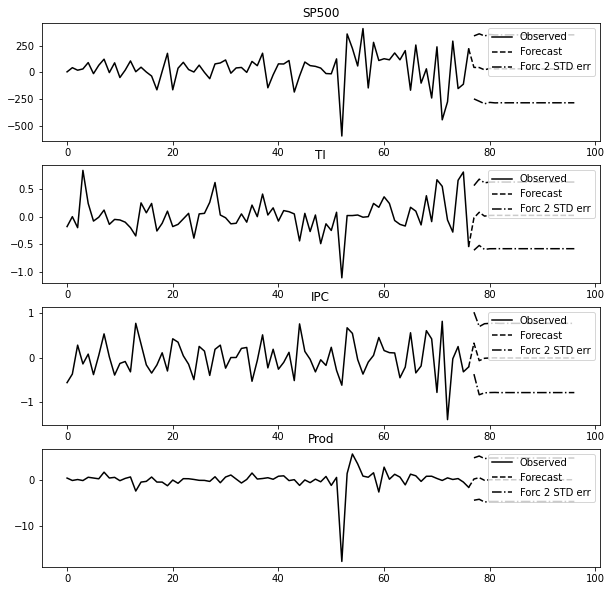

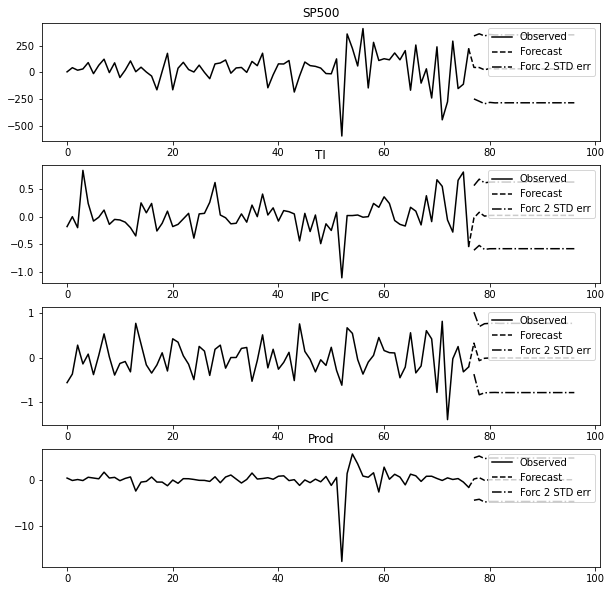

In [90]:
results.plot_forecast(20) 

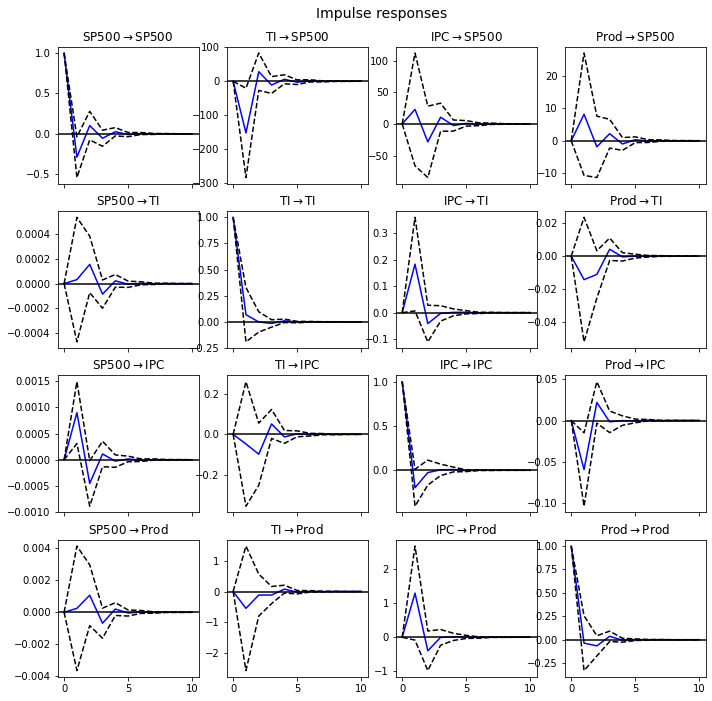

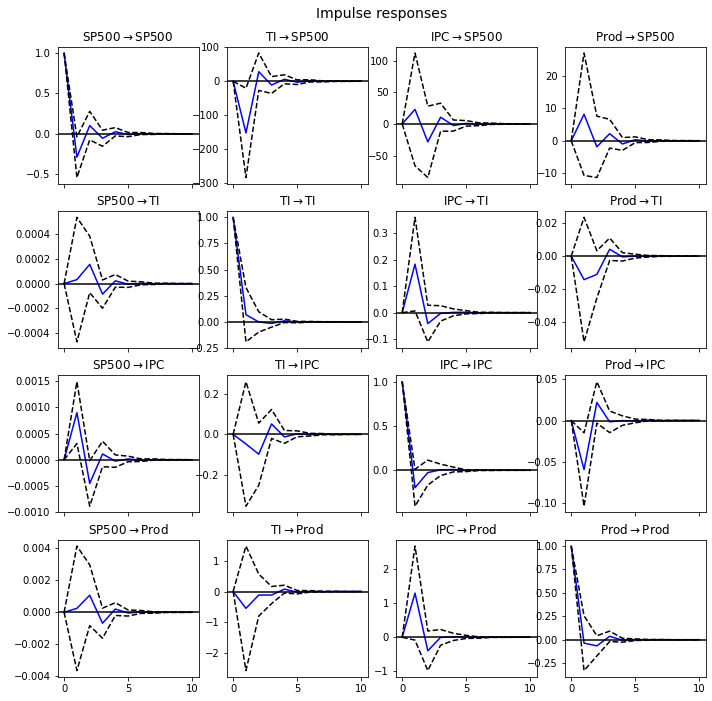

In [92]:
irf = results.irf(10)
irf.plot(orth=False)

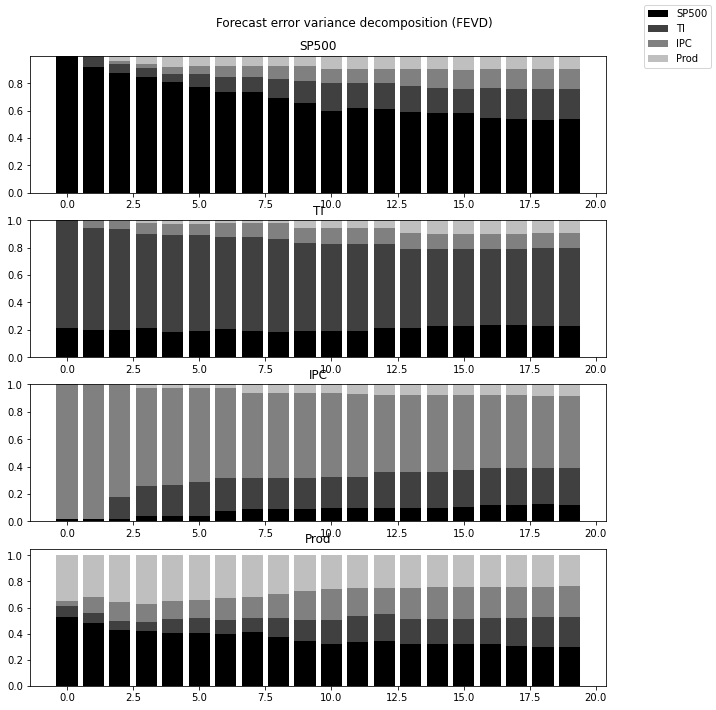

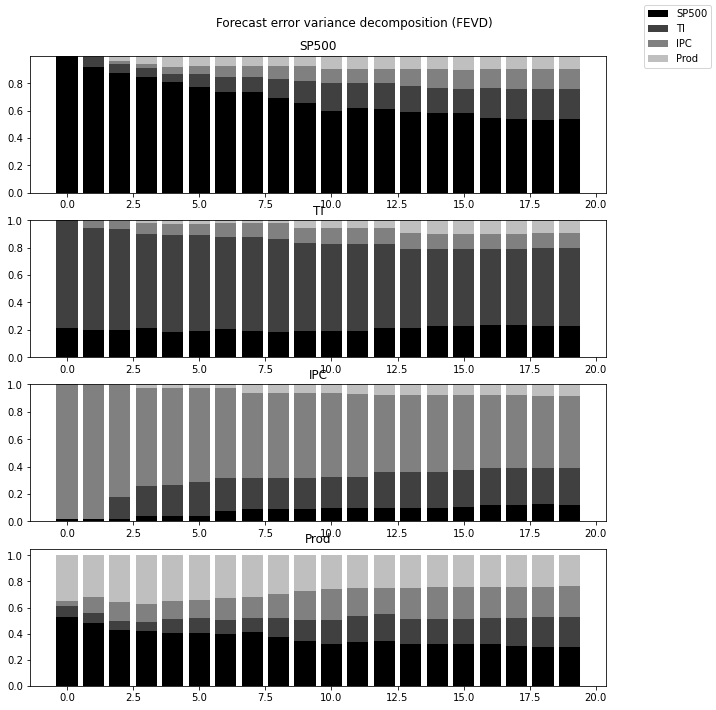

In [67]:
fevd = results.fevd(5)
results.fevd(20).plot()

## 3.4 Deep Learning <a class="anchor" id="section_3_4"></a><font color='blue' size="1.5"><i>[(Sommaire)](#sommaire)</i></font>


In [42]:
data = yf.download('^GSPC' ,start="2013-01-01", end="2023-01-01", interval="1d")


[*********************100%***********************]  1 of 1 completed


In [43]:
# Calcul de l'indicateur RSI avec une période de 15 jours
data['RSI']=ta.rsi(data.Close, length=15)

# Calcul des moyennes mobiles exponentielles avec des périodes de 20, 100 et 150 jours
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

# Calcul de la différence entre le prix de clôture ajusté et le prix d'ouverture décalé de 1 periode
data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

# Création d'une colonne "TargetClass" avec des valeurs binaires selon que la différence entre le prix de clôture ajusté et le prix d'ouverture est positive ou négative
data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

# Création d'une colonne "TargetNextClose" avec le prix de clôture ajusté décalé d'une période vers l'arrière
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [44]:
data_set = data.iloc[:, 0:11]

pd.set_option('display.max_columns', None)

data_set.head(20)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,1705.790039,1705.790039,1693.290039,1697.369995,61.465169,1683.648930,1617.626810,1582.520998,-4.390015,0,1690.910034
1,1695.300049,1695.300049,1684.910034,1690.910034,57.779079,1684.340463,1619.077963,1583.956614,4.130005,1,1697.479980
2,1693.349976,1700.180054,1688.380005,1697.479980,60.368891,1685.591846,1620.630478,1585.460235,-4.679932,0,1691.420044
3,1696.099976,1699.420044,1686.020020,1691.420044,56.918537,1686.146912,1622.032252,1586.863676,1.099976,1,1689.469971
4,1688.369995,1691.489990,1683.349976,1689.469971,55.818580,1686.463394,1623.367652,1588.222700,3.510010,1,1694.160034
5,1690.650024,1696.810059,1682.619995,1694.160034,57.914365,1687.196407,1624.769482,1589.625843,-8.489990,0,1685.390015
6,1693.880005,1695.520020,1684.829956,1685.390015,52.888051,1687.024370,1625.969888,1590.894243,-18.290039,0,1661.319946
7,1679.609985,1679.609985,1658.589966,1661.319946,42.134713,1684.576330,1626.669889,1591.827034,-5.390015,0,1655.829956
8,1661.219971,1663.599976,1652.609985,1655.829956,40.140262,1681.838580,1627.247316,1592.674755,-9.189941,0,1646.060059
9,1655.250000,1659.180054,1645.839966,1646.060059,36.817359,1678.431102,1627.619846,1593.381845,5.539917,1,1652.349976


In [45]:
#Création d'un objet MinMaxScaler avec une plage de valeurs entre 0 et 1
sc = MinMaxScaler(feature_range=(0,1))

# Normalisation des données du DataFrame "data_set" en utilisant l'objet MinMaxScaler
data_set_scaled = sc.fit_transform(data_set)

print(data_set_scaled)

[[0.02379769 0.02067304 0.02087823 ... 0.48648984 0.         0.01908671]
 [0.02049298 0.01737278 0.01822008 ... 0.51491265 1.         0.02116181]
 [0.01987864 0.01890808 0.01932076 ... 0.48552268 0.         0.0192478 ]
 ...
 [0.6971988  0.69420861 0.69332321 ... 0.34654431 0.         0.67993858]
 [0.69285762 0.69473406 0.68303321 ... 0.64735217 1.         0.70080352]
 [0.68526211 0.69783922 0.69085855 ... 0.53596261 1.         0.69771451]]


In [46]:

X = []

# Définition du nombre de bougies en arrière à utiliser pour les prévisions
backcandles = 60

print(data_set_scaled.shape[0])

# Boucle pour créer les données d'entrée du modèle en utilisant les 8 premières colonnes du DataFrame normalisé
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

# Transposition de l'axe 0 et l'axe 2 de la liste X
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
# -1 correspond a la colonne que l'on souhaite prédire donc ici la derniere colonne de notre tableau : TargetNextClose 

y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

2368
[[[2.37976866e-02 2.06730385e-02 2.08782254e-02 ... 9.14946108e-03
   0.00000000e+00 0.00000000e+00]
  [2.04929822e-02 1.73727844e-02 1.82200751e-02 ... 9.37508194e-03
   4.89941794e-04 4.93628690e-04]
  [1.98786427e-02 1.89080819e-02 1.93207551e-02 ... 9.78335993e-03
   1.01410576e-03 1.01064030e-03]
  ...
  [3.96186888e-02 3.76713787e-02 3.96438391e-02 ... 2.11846425e-02
   1.76937581e-02 2.00607627e-02]
  [4.06929658e-02 3.92979254e-02 4.12996604e-02 ... 2.24764179e-02
   1.83093423e-02 2.06129470e-02]
  [4.17987384e-02 4.15316476e-02 4.29681435e-02 ... 2.39509197e-02
   1.89785227e-02 2.12026310e-02]]

 [[2.04929822e-02 1.73727844e-02 1.82200751e-02 ... 9.37508194e-03
   4.89941794e-04 4.93628690e-04]
  [1.98786427e-02 1.89080819e-02 1.93207551e-02 ... 9.78335993e-03
   1.01410576e-03 1.01064030e-03]
  [2.07449864e-02 1.86689753e-02 1.85721642e-02 ... 9.96445676e-03
   1.48737596e-03 1.49320573e-03]
  ...
  [4.06929658e-02 3.92979254e-02 4.12996604e-02 ... 2.24764179e-02
   1.

In [47]:
splitlimit = int(len(X)*0.8)
print(splitlimit)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1846
(1846, 60, 8)
(462, 60, 8)
(1846, 1)
(462, 1)
[[0.03981581]
 [0.04142663]
 [0.04341333]
 ...
 [0.71739818]
 [0.70743948]
 [0.69146703]]


In [48]:
np.random.seed(10)

# Création de la couche d'entrée du modèle avec la forme appropriée
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
111/111 [==============================] - 4s 21ms/step - loss: 0.0013 - val_loss: 5.4703e-04
Epoch 2/30
111/111 [==============================] - 2s 18ms/step - loss: 2.1957e-04 - val_loss: 4.8125e-04
Epoch 3/30
111/111 [==============================] - 2s 18ms/step - loss: 2.0775e-04 - val_loss: 0.0012
Epoch 4/30
111/111 [==============================] - 2s 19ms/step - loss: 2.3094e-04 - val_loss: 6.7138e-04
Epoch 5/30
111/111 [==============================] - 2s 19ms/step - loss: 1.8031e-04 - val_loss: 4.3981e-04
Epoch 6/30
111/111 [==============================] - 2s 19ms/step - loss: 1.7645e-04 - val_loss: 0.0015
Epoch 7/30
111/111 [==============================] - 2s 19ms/step - loss: 1.8851e-04 - val_loss: 3.7580e-04
Epoch 8/30
111/111 [==============================] - 2s 19ms/step - loss: 1.9619e-04 - val_loss: 8.5693e-04
Epoch 9/30
111/111 [==============================] - 2s 18ms/step - loss: 1.6225e-04 - val_loss: 5.2740e-04
Epoch 10/30
111/111 [==========

In [49]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 0s 9ms/step
[0.6994492] [0.67527982]
[0.68213874] [0.69848516]
[0.6606876] [0.6919819]
[0.6723744] [0.70906607]
[0.6743684] [0.71644748]
[0.6890775] [0.7292488]
[0.6981738] [0.7305122]
[0.70978653] [0.73859786]
[0.71073896] [0.73663013]
[0.7163459] [0.74023401]


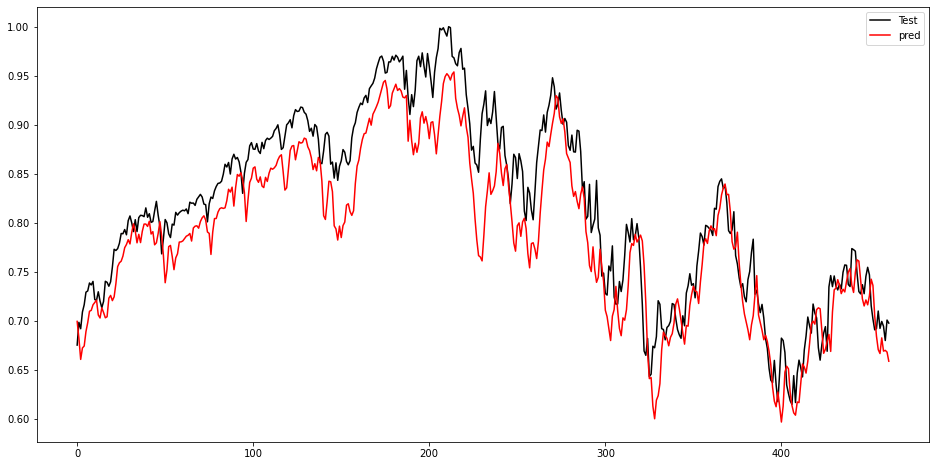

In [50]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

**On peut changer de variable à predire, prenons Target**

In [51]:
X = []

# Définition du nombre de bougies en arrière à utiliser pour les prévisions
backcandles = 60

print(data_set_scaled.shape[0])

# Boucle pour créer les données d'entrée du modèle en utilisant les 8 premières colonnes du DataFrame normalisé
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

# Transposition de l'axe 0 et l'axe 2 de la liste X
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-3])
# -1 correspond a la colonne que l'on souhaite prédire donc ici la derniere colonne de notre tableau : Target 

y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

2368
[[[2.37976866e-02 2.06730385e-02 2.08782254e-02 ... 9.14946108e-03
   0.00000000e+00 0.00000000e+00]
  [2.04929822e-02 1.73727844e-02 1.82200751e-02 ... 9.37508194e-03
   4.89941794e-04 4.93628690e-04]
  [1.98786427e-02 1.89080819e-02 1.93207551e-02 ... 9.78335993e-03
   1.01410576e-03 1.01064030e-03]
  ...
  [3.96186888e-02 3.76713787e-02 3.96438391e-02 ... 2.11846425e-02
   1.76937581e-02 2.00607627e-02]
  [4.06929658e-02 3.92979254e-02 4.12996604e-02 ... 2.24764179e-02
   1.83093423e-02 2.06129470e-02]
  [4.17987384e-02 4.15316476e-02 4.29681435e-02 ... 2.39509197e-02
   1.89785227e-02 2.12026310e-02]]

 [[2.04929822e-02 1.73727844e-02 1.82200751e-02 ... 9.37508194e-03
   4.89941794e-04 4.93628690e-04]
  [1.98786427e-02 1.89080819e-02 1.93207551e-02 ... 9.78335993e-03
   1.01410576e-03 1.01064030e-03]
  [2.07449864e-02 1.86689753e-02 1.85721642e-02 ... 9.96445676e-03
   1.48737596e-03 1.49320573e-03]
  ...
  [4.06929658e-02 3.92979254e-02 4.12996604e-02 ... 2.24764179e-02
   1.

In [52]:
splitlimit = int(len(X)*0.8)
print(splitlimit)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1846
(1846, 60, 8)
(462, 60, 8)
(1846, 1)
(462, 1)
[[0.47878389]
 [0.510943  ]
 [0.51624713]
 ...
 [0.69899342]
 [0.38987976]
 [0.35345007]]


In [53]:
np.random.seed(10)

# Création de la couche d'entrée du modèle avec la forme appropriée
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
111/111 [==============================] - 4s 28ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 2/30
111/111 [==============================] - 2s 20ms/step - loss: 0.0054 - val_loss: 0.0119
Epoch 3/30
111/111 [==============================] - 2s 21ms/step - loss: 0.0058 - val_loss: 0.0111
Epoch 4/30
111/111 [==============================] - 2s 20ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 5/30
111/111 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0133
Epoch 6/30
111/111 [==============================] - 2s 20ms/step - loss: 0.0053 - val_loss: 0.0140
Epoch 7/30
111/111 [==============================] - 2s 19ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 8/30
111/111 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 9/30
111/111 [==============================] - 2s 18ms/step - loss: 0.0053 - val_loss: 0.0112
Epoch 10/30
111/111 [==============================] - 2s 20ms/step - loss: 0.0053 - val_lo

In [54]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 0s 9ms/step
[0.502092] [0.33413448]
[0.49996907] [0.66246354]
[0.49859124] [0.42427414]
[0.5021394] [0.57956438]
[0.50190496] [0.5238867]
[0.5035835] [0.58053195]
[0.50363886] [0.56391873]
[0.50388974] [0.58780421]
[0.50294495] [0.46483882]
[0.5027187] [0.58303395]


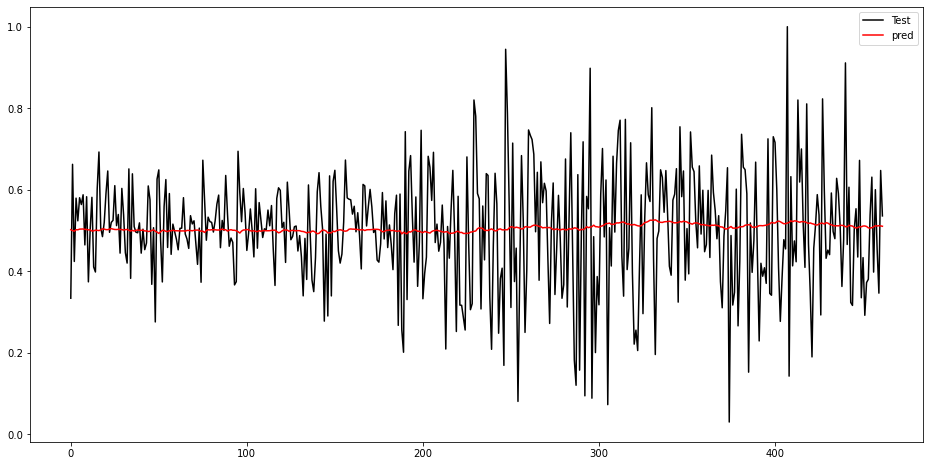

In [55]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()